In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model, fit_report

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(sc.__version__)

1.1.0


In [3]:
enrichment = 0.959
total_GT = 48
total_IAS = 16

R_square = 7.98

bin_3_35 = 0.152
bin_35_4 = 0.223

In [4]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def gauss2(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.))) / sigma

def line(x, a, b):
    return a*x+b

def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner4(x, M, w,  G1):
    a = M/(2*np.pi*G1)
    b = 1 + np.square(2*(x-w)/G1)
    return np.round(a/b, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

In [5]:
def QFC_back(E, E_qf, N_0, W = 22, T = 100):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    x = E_t_gs - E
    return N_0 * ( 1 - np.exp((x-E_0)/T) )/( 1 + ((x-E_qf)/W)**2)

def QFC_back2(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    return N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)

def QFC_back3(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

def QFC_back4(x, E_qf, N_0):
    W = 22
    T = 100
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [6]:
data_to_fit_x = np.linspace(0,30, 4000)

### red

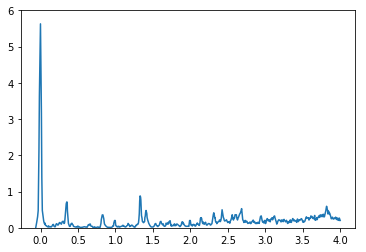

In [7]:
red_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/0/0-4.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
plt.plot(red_0_4['x'].values, red_0_4['y'].values)
plt.ylim(0,6)
plt.show()
#red_0_4.head()

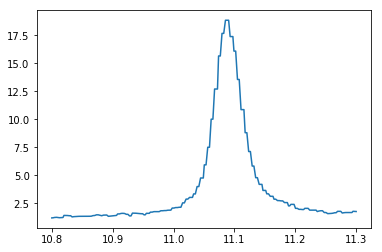

In [8]:
redIAS = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/0/IAS.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
plt.plot(redIAS['x'].values, redIAS['y'].values)
#plt.ylim(0,6)
plt.show()

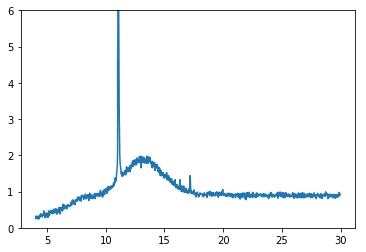

In [9]:
red_4_30 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/0/4-30.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
plt.plot(red_4_30['x'].values, red_4_30['y'].values)
plt.ylim(0,6)
plt.show()

In [10]:
def prepare_data(x_data_out, dataframe0_4, dataframeIAS, dataframe4_28, noIAS=False, distance=60):
    beginning = dataframe4_28[((dataframe4_28['x']<10.85))]
    middle = dataframeIAS[((dataframeIAS['x']>10.85) & (dataframeIAS['x']<11.25))]
    ending = dataframe4_28[((dataframe4_28['x']>11.25))]
#        beginning = dataframe4_28[((dataframe4_28['x']<10.85))]
    
    x04_data = np.linspace(0,4,len(dataframe0_4['x'].values))
    y04_data = np.interp(x04_data, dataframe0_4['x'].values, dataframe0_4['y'].values)
    
    peaks, _ = sc.signal.find_peaks(-y04_data+30, distance=distance)
    
    #y_data2 doesn't contain IAS
    y04_data = np.interp(x04_data, x04_data[peaks], y04_data[peaks])
    
    temp2 = pd.DataFrame({'x':x04_data, 'y':y04_data})
    
    #data3 - smothed data with IAS
    data3 = temp2.append(beginning).append(middle).append(ending)
    
    if noIAS == True: data3 = temp2.append(dataframe4_28)
    
    y_data_out = np.interp(x_data_out, data3['x'].values, data3['y'].values)
    
    data_full = dataframe0_4.append(beginning).append(middle).append(ending)
#    data_full = pd.DataFrame({'x':x_data_out, 
#                              'y':np.interp(x_data_out, data_full['x'].values, data_full['y'].values)})
    return data_full, y_data_out

(0, 10)

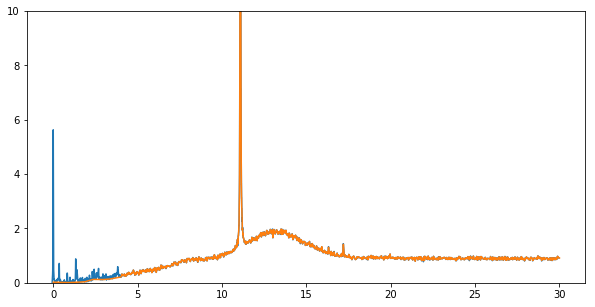

In [11]:
red_full, red_smothed = prepare_data(data_to_fit_x, red_0_4, redIAS, red_4_30)

plt.figure(figsize=(10,5))
plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(data_to_fit_x, red_smothed)
#plt.xlim(0,10)
plt.ylim(0,10)

(0, 5)

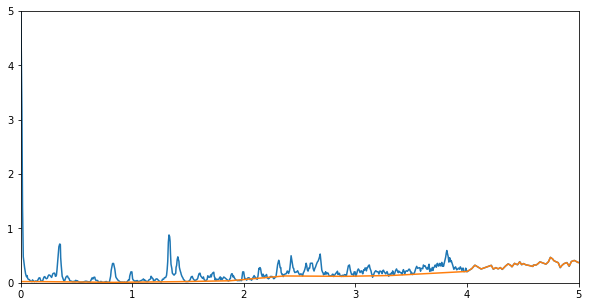

In [12]:
plt.figure(figsize=(10,5))
plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(data_to_fit_x, red_smothed)
plt.xlim(0,5)
plt.ylim(0,5)

(10, 12)

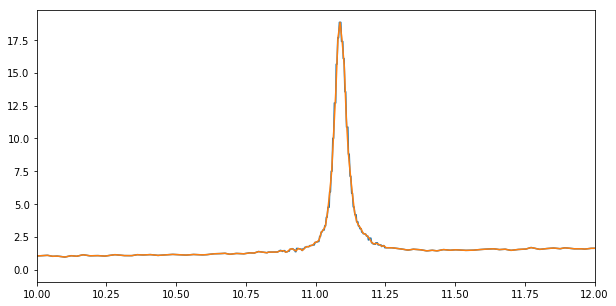

In [13]:
plt.figure(figsize=(10,5))
plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(data_to_fit_x, red_smothed)
plt.xlim(10,12)
#plt.ylim(0,5)

### yellow

In [14]:
yellow_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/1/0-4.csv', 
                      sep=';', decimal=',', names=['x','y'],)
yellowIAS = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/1/IAS.csv', 
                      sep=';', decimal=',', names=['x','y'], )
yellow_4_28 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/1/4-30.csv', 
                      sep=';', decimal=',', names=['x','y'],)

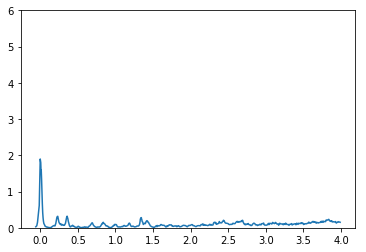

In [15]:
plt.plot(yellow_0_4['x'].values, yellow_0_4['y'].values)
plt.ylim(0,6)
plt.show()

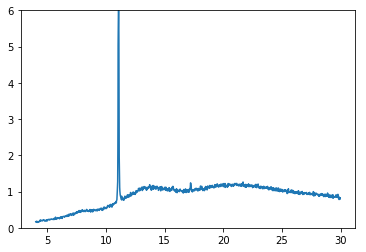

In [16]:
plt.plot(yellow_4_28['x'].values, yellow_4_28['y'].values)
plt.ylim(0,6)
plt.show()

(0, 10)

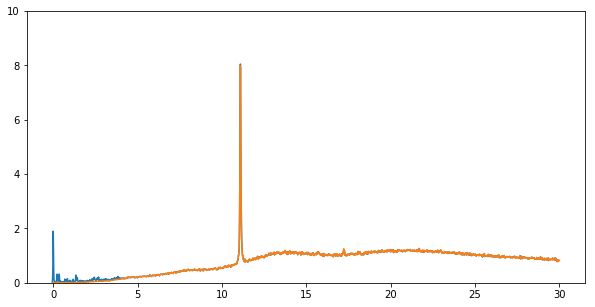

In [17]:
yellow_full, yellow_smothed = prepare_data(data_to_fit_x, yellow_0_4, yellowIAS, yellow_4_28)

plt.figure(figsize=(10,5))
plt.plot(yellow_full['x'].values, yellow_full['y'].values)
plt.plot(data_to_fit_x, yellow_smothed)
#plt.xlim(0,10)
plt.ylim(0,10)

### violet

(0, 5)

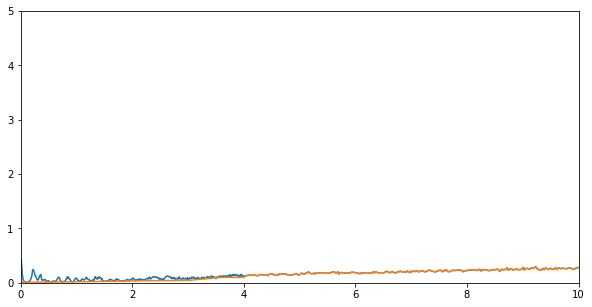

In [18]:
violet_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/2/0-4.csv', 
                         sep=';', decimal=',', names=['x','y'], header=None)
violet_4_28 = pd.read_csv('../B(GT) peaks processing/recognition/Mo100/2/4-30.csv', 
                         sep=';', decimal=',', names=['x','y'], header=None)

violet_full, violet_smothed = prepare_data(data_to_fit_x, violet_0_4, violet_4_28, 
                                           violet_4_28, noIAS=True)

plt.figure(figsize=(10,5))
plt.plot(violet_full['x'].values, violet_full['y'].values)
plt.plot(data_to_fit_x, violet_smothed)
plt.xlim(0,10)
plt.ylim(0,5)

(0, 5)

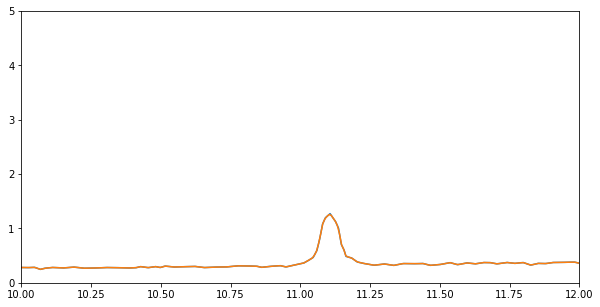

In [19]:
plt.figure(figsize=(10,5))
plt.plot(violet_full['x'].values, violet_full['y'].values)
plt.plot(data_to_fit_x, violet_smothed)
plt.xlim(10,12)
plt.ylim(0,5)

https://stackoverflow.com/questions/20339234/python-and-lmfit-how-to-fit-multiple-datasets-with-shared-parameters

https://groups.google.com/forum/#!topic/lmfit-py/orAT3mJJdL4

In [28]:

#data_to_fit_y = np.array([red_smothed, yellow_smothed, violet_smothed])
data_to_fit_y = np.array([red_smothed])

data_to_fit_x.shape, data_to_fit_y.shape

((4000,), (1, 4000))

In [29]:
def total_dataset(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
    IAS1_w = params['IAS1_w_%i' % (i+1)].value
    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
    IAS1_M = params['IAS1_M_%i' % (i+1)].value
    
    
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value
    
    
    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    out = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)\
    + breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)\
    + breit_vigner3(x, GTR_M, GTR_w, GTR_G1)\
    + breit_vigner3(x, SDR_M, SDR_w, SDR_G1)\
    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return out

def total_dataset2PR(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
    PR2_w = params['PR2_w_%i' % (i+1)].value
    PR2_G1 = params['PR2_G1_%i' % (i+1)].value
    PR2_M = params['PR2_M_%i' % (i+1)].value
    
    IAS1_w = params['IAS1_w_%i' % (i+1)].value
    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
    IAS1_M = params['IAS1_M_%i' % (i+1)].value
    
    
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value
    
    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    out = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)\
    + breit_vigner3(x, PR2_M, PR2_w, PR2_G1)\
    + breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)\
    + breit_vigner3(x, GTR_M, GTR_w, GTR_G1)\
    + breit_vigner3(x, SDR_M, SDR_w, SDR_G1)\
    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return out

In [30]:
def total_dataset_for_plot(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
    IAS1_w = params['IAS1_w_%i' % (i+1)].value
    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
    IAS1_M = params['IAS1_M_%i' % (i+1)].value
    
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value
    
    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    PR1 = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)
    IAS1 = breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)
    GTR = breit_vigner3(x, GTR_M, GTR_w, GTR_G1)
    SDR = breit_vigner3(x, SDR_M, SDR_w, SDR_G1)
    QFC = QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return PR1, IAS1, GTR, SDR, QFC


def total_dataset_for_plot2PR(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
    PR2_w = params['PR2_w_%i' % (i+1)].value
    PR2_G1 = params['PR2_G1_%i' % (i+1)].value
    PR2_M = params['PR2_M_%i' % (i+1)].value
    
    IAS1_w = params['IAS1_w_%i' % (i+1)].value
    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
    IAS1_M = params['IAS1_M_%i' % (i+1)].value
    
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value
    
    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    PR1 = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)
    PR2 = breit_vigner3(x, PR2_M, PR2_w, PR2_G1)
    IAS1 = breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)
    GTR = breit_vigner3(x, GTR_M, GTR_w, GTR_G1)
    SDR = breit_vigner3(x, SDR_M, SDR_w, SDR_G1)
    QFC = QFC_back4(x, QFC_Eqf, QFC_N0)
    
#    return PR1, PR2, PR3, IAS1, IAS2, GTR, SDR, QFC
    return PR1, PR2, IAS1, GTR, SDR, QFC

In [31]:
#def gauss2(x, mu, sigma, k):
#    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.))) / sigma



def total_dataset_gauss(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_mu = params['PR1_mu_%i' % (i+1)].value
    PR1_sigma = params['PR1_sigma_%i' % (i+1)].value
    PR1_k = params['PR1_k_%i' % (i+1)].value
    
    IAS1_mu = params['IAS1_mu_%i' % (i+1)].value
    IAS1_sigma = params['IAS1_sigma_%i' % (i+1)].value
    IAS1_k = params['IAS1_k_%i' % (i+1)].value
    
    
    GTR_mu = params['GTR_mu_%i' % (i+1)].value
    GTR_sigma = params['GTR_sigma_%i' % (i+1)].value
    GTR_k = params['GTR_k_%i' % (i+1)].value
    
    
    SDR_mu = params['SDR_mu_%i' % (i+1)].value
    SDR_sigma = params['SDR_sigma_%i' % (i+1)].value
    SDR_k = params['SDR_k_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    out = gauss2(x, PR1_mu, PR1_sigma, PR1_k)\
    + gauss2(x, IAS1_mu, IAS1_sigma, IAS1_k)\
    + gauss2(x, GTR_mu, GTR_sigma, GTR_k)\
    + gauss2(x, SDR_mu, SDR_sigma, SDR_k)\
    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return out

def total_dataset_for_plot_gauss(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_mu = params['PR1_mu_%i' % (i+1)].value
    PR1_sigma = params['PR1_sigma_%i' % (i+1)].value
    PR1_k = params['PR1_k_%i' % (i+1)].value
    
    IAS1_mu = params['IAS1_mu_%i' % (i+1)].value
    IAS1_sigma = params['IAS1_sigma_%i' % (i+1)].value
    IAS1_k = params['IAS1_k_%i' % (i+1)].value
    
    
    GTR_mu = params['GTR_mu_%i' % (i+1)].value
    GTR_sigma = params['GTR_sigma_%i' % (i+1)].value
    GTR_k = params['GTR_k_%i' % (i+1)].value
    
    
    SDR_mu = params['SDR_mu_%i' % (i+1)].value
    SDR_sigma = params['SDR_sigma_%i' % (i+1)].value
    SDR_k = params['SDR_k_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    PR1 = gauss2(x, PR1_mu, PR1_sigma, PR1_k)
    IAS1 = gauss2(x, IAS1_mu, IAS1_sigma, IAS1_k)
    GTR = gauss2(x, GTR_mu, GTR_sigma, GTR_k)
    SDR = gauss2(x, SDR_mu, SDR_sigma, SDR_k)
    QFC = QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return PR1, IAS1, GTR, SDR, QFC

In [32]:
def total_dataset2PR_gauss(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_mu = params['PR1_mu_%i' % (i+1)].value
    PR1_sigma = params['PR1_sigma_%i' % (i+1)].value
    PR1_k = params['PR1_k_%i' % (i+1)].value
    
    PR2_mu = params['PR2_mu_%i' % (i+1)].value
    PR2_sigma = params['PR2_sigma_%i' % (i+1)].value
    PR2_k = params['PR2_k_%i' % (i+1)].value
    
    IAS1_mu = params['IAS1_mu_%i' % (i+1)].value
    IAS1_sigma = params['IAS1_sigma_%i' % (i+1)].value
    IAS1_k = params['IAS1_k_%i' % (i+1)].value
    
    
    GTR_mu = params['GTR_mu_%i' % (i+1)].value
    GTR_sigma = params['GTR_sigma_%i' % (i+1)].value
    GTR_k = params['GTR_k_%i' % (i+1)].value
    
    
    SDR_mu = params['SDR_mu_%i' % (i+1)].value
    SDR_sigma = params['SDR_sigma_%i' % (i+1)].value
    SDR_k = params['SDR_k_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    out = gauss2(x, PR1_mu, PR1_sigma, PR1_k)\
    + gauss2(x, PR2_mu, PR2_sigma, PR2_k)\
    + gauss2(x, IAS1_mu, IAS1_sigma, IAS1_k)\
    + gauss2(x, GTR_mu, GTR_sigma, GTR_k)\
    + gauss2(x, SDR_mu, SDR_sigma, SDR_k)\
    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return out


def total_dataset_for_plot2PR_gauss(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_mu = params['PR1_mu_%i' % (i+1)].value
    PR1_sigma = params['PR1_sigma_%i' % (i+1)].value
    PR1_k = params['PR1_k_%i' % (i+1)].value
    
    PR2_mu = params['PR2_mu_%i' % (i+1)].value
    PR2_sigma = params['PR2_sigma_%i' % (i+1)].value
    PR2_k = params['PR2_k_%i' % (i+1)].value
    
    IAS1_mu = params['IAS1_mu_%i' % (i+1)].value
    IAS1_sigma = params['IAS1_sigma_%i' % (i+1)].value
    IAS1_k = params['IAS1_k_%i' % (i+1)].value
    
    
    GTR_mu = params['GTR_mu_%i' % (i+1)].value
    GTR_sigma = params['GTR_sigma_%i' % (i+1)].value
    GTR_k = params['GTR_k_%i' % (i+1)].value
    
    
    SDR_mu = params['SDR_mu_%i' % (i+1)].value
    SDR_sigma = params['SDR_sigma_%i' % (i+1)].value
    SDR_k = params['SDR_k_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    PR1 = gauss2(x, PR1_mu, PR1_sigma, PR1_k)
    PR2 = gauss2(x, PR2_mu, PR2_sigma, PR2_k)
    IAS1 = gauss2(x, IAS1_mu, IAS1_sigma, IAS1_k)
    GTR = gauss2(x, GTR_mu, GTR_sigma, GTR_k)
    SDR = gauss2(x, SDR_mu, SDR_sigma, SDR_k)
    QFC = QFC_back4(x, QFC_Eqf, QFC_N0)
    
#    return PR1, PR2, PR3, IAS1, IAS2, GTR, SDR, QFC
    return PR1, PR2, IAS1, GTR, SDR, QFC

In [33]:
def objective(params, x, data):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by our functions"""
    ndata, nx = data.shape
    resid = 0.0*data[:]
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - total_dataset(params, i, x)
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

def objective_gauss(params, x, data):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by our functions"""
    ndata, nx = data.shape
    resid = 0.0*data[:]
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - total_dataset_gauss(params, i, x)
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

def objective2PR(params, x, data):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by our functions"""
    ndata, nx = data.shape
    resid = 0.0*data[:]
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - total_dataset2PR(params, i, x)
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

def objective2PR_gauss(params, x, data):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by our functions"""
    ndata, nx = data.shape
    resid = 0.0*data[:]
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - total_dataset2PR_gauss(params, i, x)
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

In [34]:
fit_params = Parameters()
for iy, y in enumerate(data_to_fit_y):
    fit_params.add( 'PR1_w_%i' % (iy+1), value=8, min=8, max=10)
    fit_params.add( 'PR1_G1_%i' % (iy+1), value=0.1, min=0.1, max=2)
    fit_params.add( 'PR1_M_%i' % (iy+1), value=0.5, min=0.1, max= 0.95)
    
    fit_params.add( 'IAS1_w_%i' % (iy+1), value=11.085, min=11.0, max=11.2)
    fit_params.add( 'IAS1_G1_%i' % (iy+1), value=0.01, min=0.01, max=0.03)
    fit_params.add( 'IAS1_M_%i' % (iy+1), value=0.5, min=0.05, max=0.7)

    fit_params.add( 'GTR_w_%i' % (iy+1), value=13.0, min=12, max=14)
    fit_params.add( 'GTR_G1_%i' % (iy+1), value=2, min=2, max=4)
    fit_params.add( 'GTR_M_%i' % (iy+1), value=0.5, min=0.1, max= 15)
    
    fit_params.add( 'SDR_w_%i' % (iy+1), value=21, min=18, max=25)
    fit_params.add( 'SDR_G1_%i' % (iy+1), value=0.01, min=0.1, max=10)
    fit_params.add( 'SDR_M_%i' % (iy+1), value=0.5, min=0.1, max= 5)
    
    fit_params.add( 'QFC_Eqf_%i' % (iy+1), value=400, max=410, min=385 )
    fit_params.add( 'QFC_N0_%i' % (iy+1), value=8, max=15, min=1 )
    
# but now constrain all values of sigma to have the same value
# by assigning sig_2, sig_3, .. sig_5 to be equal to sig_1
#fit_params['GTR_74_M_1'].expr='GTR_M_1 / 7'
#fit_params['GTR_74_G1_1'].expr='GTR_G1_1 * 0.9'
#fit_params['GTR_74_M_3'].expr='GTR_M_3 / 7'



#for iy in (2, 3):
#    fit_params['PR1_w_%i' % iy].expr='PR1_w_1'
#    fit_params['PR1_G1_%i' % iy].expr='PR1_G1_1'
#    
#    fit_params['IAS1_G1_%i' % iy].expr='IAS1_G1_1'
    
#    fit_params['GTR_w_%i' % iy].expr='GTR_w_1'
#    fit_params['GTR_G1_%i' % iy].expr='GTR_G1_1'
    
#    fit_params['SDR_w_%i' % iy].expr='SDR_w_1'
#    fit_params['SDR_G1_%i' % iy].expr='SDR_G1_1'
    
#    fit_params['QFC_Eqf_%i' % iy].expr='QFC_Eqf_1'

In [35]:
#fit_params

In [38]:
result = minimize(objective, fit_params, args=(data_to_fit_x, data_to_fit_y), 
                  method='differential_evolution')

In [39]:
print(fit_report(result))

[[Fit Statistics]]
    # function evals   = 31171
    # data points      = 4000
    # variables        = 14
    chi-square         = 12.259
    reduced chi-square = 0.003
    Akaike info crit   = -23123.308
    Bayesian info crit = -23035.192
[[Variables]]
    PR1_w_1:     8.00131737 (init= 8)
    PR1_G1_1:    1.99792246 (init= 0.1)
    PR1_M_1:     0.94737754 (init= 0.5)
    IAS1_w_1:    11.0894499 (init= 11.085)
    IAS1_G1_1:   0.02361667 (init= 0.01)
    IAS1_M_1:    0.42623056 (init= 0.5)
    GTR_w_1:     13.1612638 (init= 13)
    GTR_G1_1:    2.61059511 (init= 2)
    GTR_M_1:     4.12637128 (init= 0.5)
    SDR_w_1:     20.7775558 (init= 21)
    SDR_G1_1:    5.92199774 (init= 0.1)
    SDR_M_1:     1.87206511 (init= 0.5)
    QFC_Eqf_1:   390.056861 (init= 400)
    QFC_N0_1:    3.89768425 (init= 8)


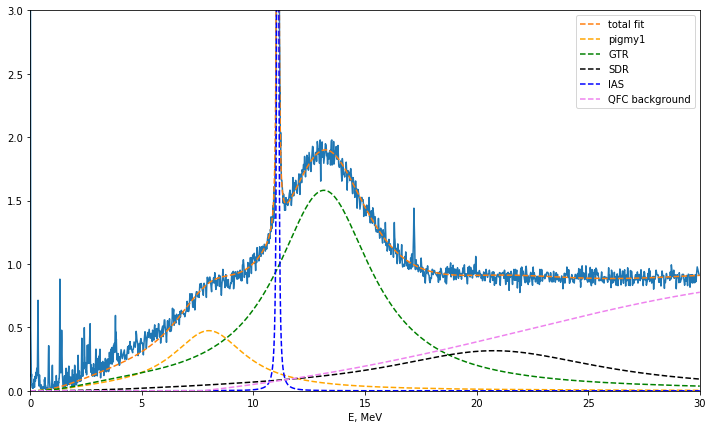

In [40]:
i = 0
plt.figure(figsize=(12,7))
y_fit = total_dataset(result.params, i, data_to_fit_x)
plt.plot(red_full['x'].values, red_full['y'].values)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,3)
plt.xlim(0,30)
plt.legend()
plt.show()

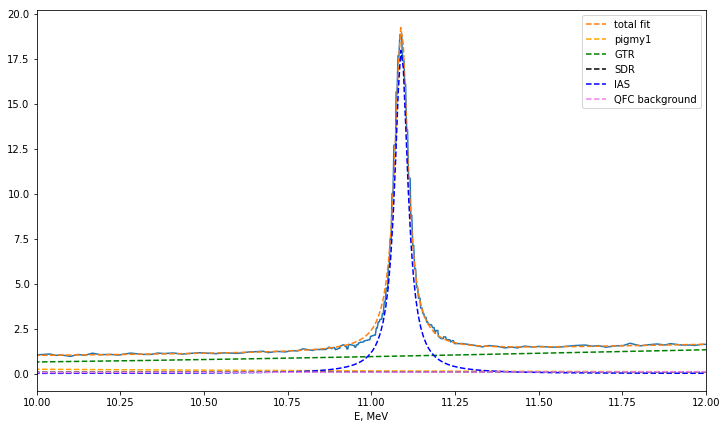

In [42]:
i = 0
plt.figure(figsize=(12,7))
y_fit = total_dataset(result.params, i, data_to_fit_x)
plt.plot(red_full['x'].values, red_full['y'].values)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
#plt.ylim(0,3)
plt.xlim(10,12)
plt.legend()
plt.show()

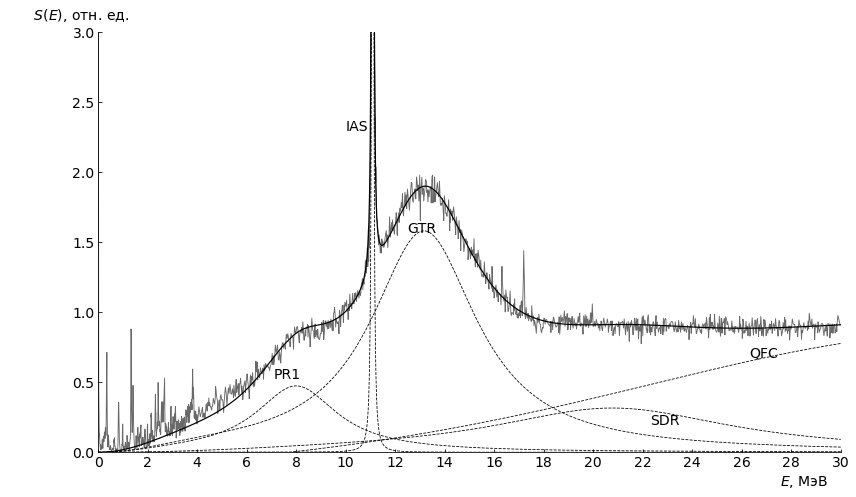

In [43]:
i = 0

f, ax = plt.subplots(figsize=(12,7))

y_fit = total_dataset(result.params, i, data_to_fit_x)
ax.plot(red_full['x'].values, red_full['y'].values, 'dimgrey', linewidth=0.9)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
ax.plot(data_to_fit_x, y_fit, 'k', ls='-', linewidth=1.2, label='total fit')

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

ax.plot(data_to_fit_x, PR1, 'k', label='pigmy1', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, GTR, 'k', label='GTR', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, SDR, 'k', label='SDR', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, IAS1, 'k', label='IAS', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, QFC, 'k', label='QFC background', ls='--', linewidth=0.8)

ax.text(12.5, 1.57, 'GTR',  fontsize=14)
ax.text(26.3, 0.68, 'QFC',  fontsize=14)
ax.text(22.3, 0.2, 'SDR',  fontsize=14)
ax.text(10.0, 2.3, 'IAS',  fontsize=14, rotation=0)
ax.text(7.1, 0.53, 'PR1',  fontsize=14)

ax.set_ylabel('      $S(E)$, отн. ед.', x=0, y=1.02, rotation=0, fontsize=14)
ax.set_xlabel('$E$, МэВ', x=0.95, y=-0.15, fontsize=14)
ax.set_xticks(np.arange(0,32,2))

ax.tick_params(direction='in', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.ylabel('S(E), 1/MeV')
ax.set_ylim(0,3)
ax.set_xlim(0,30)
#plt.legend()
plt.tight_layout()

#plt.savefig("Mo100_decomposition.png", format='png', transparent=False, dpi=500)

plt.show()

In [44]:
y_angleRED = np.interp(data_to_fit_x, red_full['x'].values, red_full['y'].values)

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, 0, data_to_fit_x)
#data_no_SDR_QFC = y_angleRED - SDR - QFC - IAS1
data_no_SDR_QFC = pd.DataFrame(data={'x':data_to_fit_x, 'y':y_angleRED-SDR-QFC-IAS1})
begining = data_no_SDR_QFC[data_no_SDR_QFC['x']<10.75]
ending = data_no_SDR_QFC[data_no_SDR_QFC['x']>11.5]
data_no_SDR_QFC_IAS = begining.append(ending)
data_no_SDR_QFC_IAS.head()

,x,y
0,0.000000,5.531765
1,0.007502,4.051480
2,0.015004,2.203262
3,0.022506,0.713529
4,0.030008,0.381334


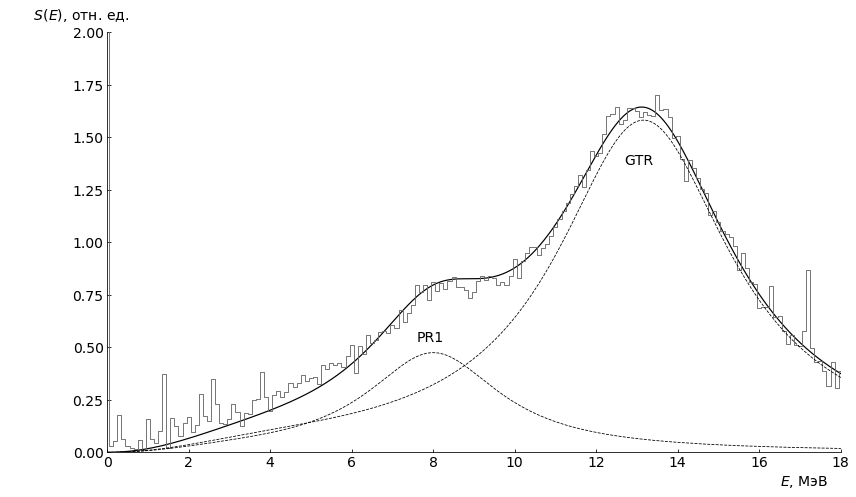

In [45]:
f, ax = plt.subplots(figsize=(12,7))

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, 0, data_to_fit_x)
PR1_GTR = PR1 + GTR 

y_PR_GTR = np.interp(np.arange(0,30,0.1), data_no_SDR_QFC_IAS['x'].values, data_no_SDR_QFC_IAS['y'].values)

#ax.plot(red_full['x'].values, red_full['y'].values, 'dimgrey', linewidth=0.9)
ax.plot(data_to_fit_x, PR1_GTR, 'k', ls='-', linewidth=1.2, label='total fit')
#ax.plot(data_no_SDR_QFC_IAS['x'].values, data_no_SDR_QFC_IAS['y'].values, 'dimgrey', linewidth=0.9)

ax.step(np.arange(0,30,0.1), y_PR_GTR, where='mid', color='dimgrey', linewidth=0.9)

ax.plot(data_to_fit_x, PR1, 'k', label='pigmy1', ls='--', linewidth=0.8)
ax.plot(data_to_fit_x, GTR, 'k', label='GTR', ls='--', linewidth=0.8)

ax.text(12.7, 1.37, 'GTR',  fontsize=14)
ax.text(7.6, 0.53, 'PR1',  fontsize=14)

ax.set_ylabel('      $S(E)$, отн. ед.', x=0, y=1.02, rotation=0, fontsize=14)
ax.set_xlabel('$E$, МэВ', x=0.95, y=-0.15, fontsize=14)
ax.set_xticks(np.arange(0,32,2))

ax.tick_params(direction='in', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.ylabel('S(E), 1/MeV')
ax.set_ylim(0,2)
ax.set_xlim(0,18)
#plt.legend()
plt.tight_layout()
plt.show()

In [46]:
i = 1
plt.figure(figsize=(10,5))
y_fit = total_dataset(result.params, i, data_to_fit_x)
plt.plot(yellow_full['x'].values, yellow_full['y'].values)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,3)
plt.xlim(0,30)
plt.legend()
plt.show()

KeyError: 'PR1_w_2'

<Figure size 720x360 with 0 Axes>

In [47]:
i = 2
plt.figure(figsize=(10,5))
y_fit = total_dataset(result.params, i, data_to_fit_x)
plt.plot(violet_full['x'].values, violet_full['y'].values)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,3)
plt.xlim(0,30)
plt.legend()
plt.show()

KeyError: 'PR1_w_3'

<Figure size 720x360 with 0 Axes>

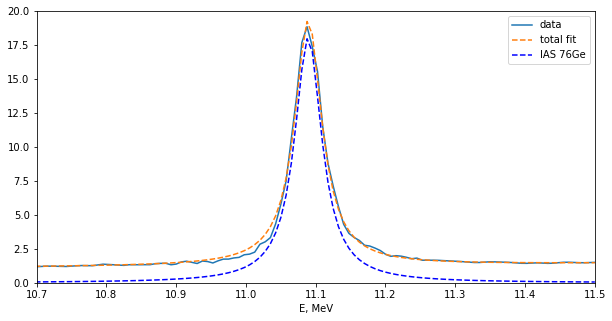

In [48]:
i = 0
plt.figure(figsize=(10,5))
y_fit = total_dataset(result.params, i, data_to_fit_x)
plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS 76Ge')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,20)
plt.xlim(10.7,11.5)
plt.legend()
plt.show()

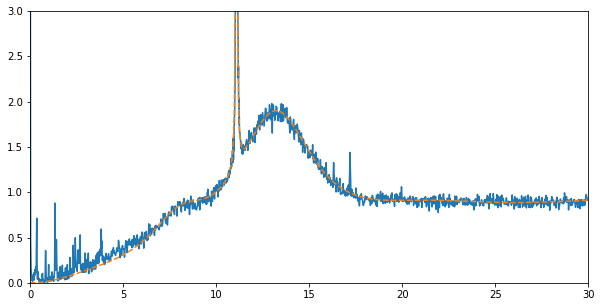

In [49]:
plt.figure(figsize=(10,5))
plt.plot(red_full['x'].values, red_full['y'].values)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')
plt.ylim(0,3)
plt.xlim(0,30)
plt.show()

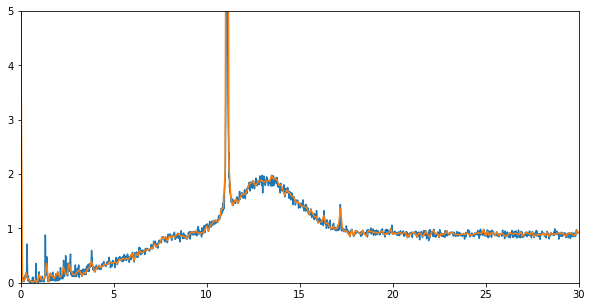

In [50]:
x_temp = np.arange(0,30.2,0.1)
y_temp = np.interp(x_temp, red_full['x'].values, red_full['y'].values)

plt.figure(figsize=(10,5))
plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(x_temp, y_temp)
plt.ylim(0,5)
plt.xlim(0,30)
plt.show()

In [51]:
#output = pd.DataFrame(data={'Ex, MeV':x_temp, 'S(E), Counts': y_temp})
#output.head()
PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, 0, data_to_fit_x)
output = pd.DataFrame(data={'Ex, MeV':data_to_fit_x,
                            'PR+GTR':PR1+GTR,
                            'IAS':IAS1})
output.head()

,"Ex, MeV",IAS,PR+GTR
0,0.000000,0.00000,0.00000
1,0.007502,0.00001,0.00000
2,0.015004,0.00003,0.00000
3,0.022506,0.00005,0.00000
4,0.030008,0.00007,0.00002


In [52]:
#output.to_excel('Mo100_BW_1PR_decomp.xls', index=False)

In [53]:
def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

In [54]:
PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot(result.params, 0, data_to_fit_x)

BWfit_3_35 = trapz(border_func2(data_to_fit_x, PR1+GTR, 3, 3.5), data_to_fit_x)
BWfit_35_4 = trapz(border_func2(data_to_fit_x, PR1+GTR, 3.5, 4), data_to_fit_x)

bin_3_35/bin_35_4, BWfit_3_35/BWfit_35_4

(0.6816143497757847, 0.8070955818445987)

In [55]:
bin_3_35/BWfit_3_35, bin_35_4/BWfit_35_4, (bin_3_35+bin_35_4)/(BWfit_3_35+BWfit_35_4)

(2.058400730644078, 2.4373403170209342, 2.2680961060209865)

In [56]:
k = (bin_3_35+bin_35_4)/(BWfit_3_35+BWfit_35_4)

GT_summ_BW = trapz(PR1+GTR, data_to_fit_x)*k
GT_summ_BW, trapz(PR1+GTR, data_to_fit_x), (GT_summ_BW + 0.6)/total_GT

(31.599329848212808, 13.93209474868717, 0.6708193718377667)

$R^2=\frac{d\sigma^{q=0}_{GT}}{d\sigma^{q=0}_{F}}*\frac{B(F)}{B(GT)}$  
т.к. B(GT)/B(F) = 3 то $3R^2=\frac{d\sigma^{q=0}_{GT}}{d\sigma^{q=0}_{F}}$. 

In [57]:
Area_GT_BW = trapz(PR1+GTR, data_to_fit_x)
Area_IAS_BW = trapz(IAS1, data_to_fit_x)


Area_GT_BW/Area_IAS_BW, 3*R_square, 3*R_square*Area_IAS_BW 

(10.415749161667831, 23.94, 32.02211795873965)

In [58]:
trapz(PR1+GTR, data_to_fit_x)/trapz(IAS1, data_to_fit_x), trapz(IAS1, data_to_fit_x), (total_IAS)/trapz(IAS1, data_to_fit_x) 

(10.415749161667831, 1.3375989122280554, 11.961732215637495)

### try to fit with gauss

In [60]:
fit_params_gauss = Parameters()
for iy, y in enumerate(data_to_fit_y):
    fit_params_gauss.add( 'PR1_mu_%i' % (iy+1), value=8, min=5, max=10)
    fit_params_gauss.add( 'PR1_sigma_%i' % (iy+1), value=0.1, min=0.01, max=20)
    fit_params_gauss.add( 'PR1_k_%i' % (iy+1), value=0.5, min=0.01, max= 20)
    
    fit_params_gauss.add( 'IAS1_mu_%i' % (iy+1), value=11.085, min=11.0, max=11.2)
    fit_params_gauss.add( 'IAS1_sigma_%i' % (iy+1), value=0.01, min=0.01, max=5)
    fit_params_gauss.add( 'IAS1_k_%i' % (iy+1), value=0.5, min=0.05, max=2)

    fit_params_gauss.add( 'GTR_mu_%i' % (iy+1), value=13.0, min=12, max=14)
    fit_params_gauss.add( 'GTR_sigma_%i' % (iy+1), value=2, min=0.01, max=20)
    fit_params_gauss.add( 'GTR_k_%i' % (iy+1), value=0.5, min=0.01, max= 20)
    
    fit_params_gauss.add( 'SDR_mu_%i' % (iy+1), value=21, min=18, max=25)
    fit_params_gauss.add( 'SDR_sigma_%i' % (iy+1), value=0.01, min=0.01, max=20)
    fit_params_gauss.add( 'SDR_k_%i' % (iy+1), value=0.5, min=0.01, max= 20)
    
    fit_params_gauss.add( 'QFC_Eqf_%i' % (iy+1), value=400, max=410, min=385 )
    fit_params_gauss.add( 'QFC_N0_%i' % (iy+1), value=8, max=15, min=1 )
    
# but now constrain all values of sigma to have the same value
# by assigning sig_2, sig_3, .. sig_5 to be equal to sig_1
#fit_params['GTR_74_M_1'].expr='GTR_M_1 / 7'
#fit_params['GTR_74_G1_1'].expr='GTR_G1_1 * 0.9'
#fit_params['GTR_74_M_3'].expr='GTR_M_3 / 7'



#for iy in (2, 3):
#    fit_params_gauss['PR1_mu_%i' % iy].expr='PR1_mu_1'
#    fit_params_gauss['PR1_sigma_%i' % iy].expr='PR1_sigma_1'
    
#    fit_params_gauss['IAS1_mu_%i' % iy].expr='IAS1_mu_1'
#    fit_params_gauss['IAS1_sigma_%i' % iy].expr='IAS1_sigma_1'
    
#    fit_params_gauss['GTR_mu_%i' % iy].expr='GTR_mu_1'
#    fit_params_gauss['GTR_sigma_%i' % iy].expr='GTR_sigma_1'
    
#    fit_params_gauss['SDR_mu_%i' % iy].expr='SDR_mu_1'
#    fit_params_gauss['SDR_sigma_%i' % iy].expr='SDR_sigma_1'
    
#    fit_params_gauss['QFC_Eqf_%i' % iy].expr='QFC_Eqf_1'

In [61]:
result_gauss = minimize(objective_gauss, fit_params_gauss, args=(data_to_fit_x, data_to_fit_y), 
                  method='differential_evolution')

In [62]:
print(fit_report(result_gauss))

[[Fit Statistics]]
    # function evals   = 46261
    # data points      = 4000
    # variables        = 14
    chi-square         = 35.740
    reduced chi-square = 0.009
    Akaike info crit   = -18843.136
    Bayesian info crit = -18755.019
[[Variables]]
    PR1_mu_1:       7.39689149 (init= 8)
    PR1_sigma_1:    2.14145847 (init= 0.1)
    PR1_k_1:        1.19717751 (init= 0.5)
    IAS1_mu_1:      11.0895807 (init= 11.085)
    IAS1_sigma_1:   0.02458224 (init= 0.01)
    IAS1_k_1:       0.39963654 (init= 0.5)
    GTR_mu_1:       12.8799476 (init= 13)
    GTR_sigma_1:    2.12748444 (init= 2)
    GTR_k_1:        2.75012065 (init= 0.5)
    SDR_mu_1:       18         (init= 21)
    SDR_sigma_1:    8.42425008 (init= 0.01)
    SDR_k_1:        1.91902447 (init= 0.5)
    QFC_Eqf_1:      410        (init= 400)
    QFC_N0_1:       7.28899662 (init= 8)


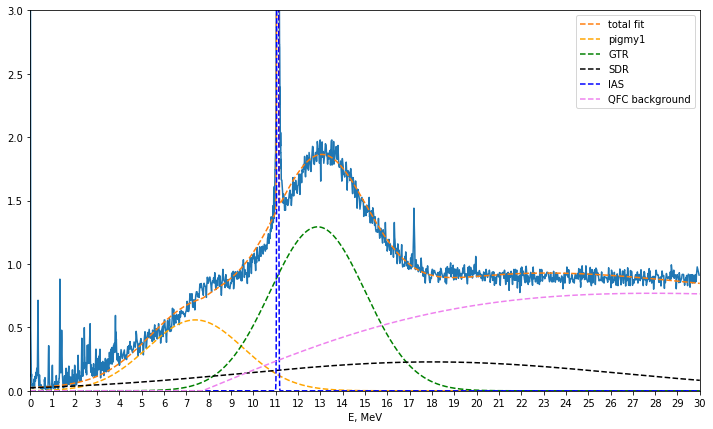

In [63]:
i = 0
plt.figure(figsize=(12,7))
y_fit = total_dataset_gauss(result_gauss.params, i, data_to_fit_x)
plt.plot(red_full['x'].values, red_full['y'].values)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot_gauss(result_gauss.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.xticks(np.arange(0,32,1))
plt.ylim(0,3)
plt.xlim(0,30)
plt.legend()
plt.show()

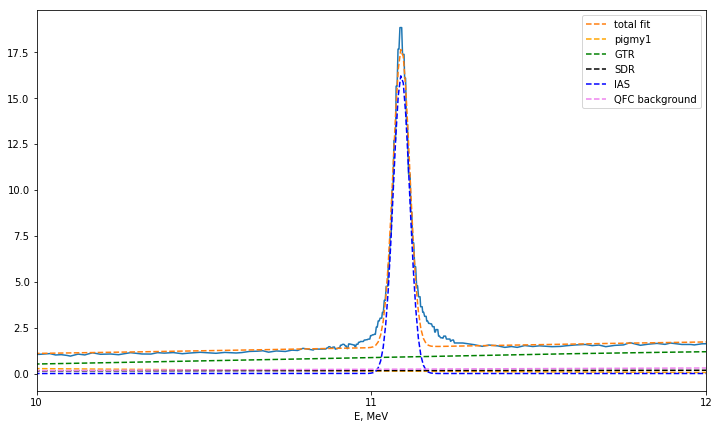

In [64]:
i = 0
plt.figure(figsize=(12,7))
y_fit = total_dataset_gauss(result_gauss.params, i, data_to_fit_x)
plt.plot(red_full['x'].values, red_full['y'].values)
#plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot_gauss(result_gauss.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.xticks(np.arange(0,32,1))
#plt.ylim(0,3)
plt.xlim(10,12)
plt.legend()
plt.show()

In [83]:
PR1, IAS1, GTR, SDR, QFC = total_dataset_for_plot_gauss(result_gauss.params, i, data_to_fit_x)

Gfit_3_35 = trapz(border_func2(data_to_fit_x, PR1+GTR, 3, 3.5), data_to_fit_x)
Gfit_35_4 = trapz(border_func2(data_to_fit_x, PR1+GTR, 3.5, 4), data_to_fit_x)

bin_3_35/bin_35_4, Gfit_3_35/Gfit_35_4

(0.6816143497757847, 0.7029433053317637)

In [84]:
bin_3_35/Gfit_3_35, bin_35_4/Gfit_35_4, (bin_3_35+bin_35_4)/(Gfit_3_35+Gfit_35_4)

(2.1713823057477364, 2.2393288164242904, 2.211281761275011)

In [86]:
k = (bin_3_35+bin_35_4)/(Gfit_3_35+Gfit_35_4)

GT_summ_G = trapz(PR1+GTR, data_to_fit_x)*k
GT_summ_G, trapz(PR1+GTR, data_to_fit_x), (GT_summ_G+0.6)/total_GT

(26.206095460994806, 11.85108832349096, 0.5584603221040585)

In [87]:
Area_GT_G = trapz(PR1+GTR, data_to_fit_x)
Area_IAS_G = trapz(IAS1, data_to_fit_x)


Area_GT_G/Area_IAS_G, 3*R_square, 3*R_square*Area_IAS_G

(11.631217359446373, 23.94, 24.39255029775129)

In [92]:
trapz(PR1+GTR, data_to_fit_x)/trapz(IAS1, data_to_fit_x), trapz(IAS1, data_to_fit_x), (total_IAS)/trapz(IAS1, data_to_fit_x) 

(11.631217359446373, 1.018903521209327, 15.70315507498664)

## gauss 2PR

In [76]:
fit_params_gauss_2PR = Parameters()
for iy, y in enumerate(data_to_fit_y):
    fit_params_gauss_2PR.add( 'PR1_mu_%i' % (iy+1), value=8.5, min=5, max=10)
    fit_params_gauss_2PR.add( 'PR1_sigma_%i' % (iy+1), value=0.1, min=0.01, max=5)
    fit_params_gauss_2PR.add( 'PR1_k_%i' % (iy+1), value=0.5, min=0.01, max= 5)
    
    fit_params_gauss_2PR.add( 'PR2_mu_%i' % (iy+1), value=5, min=3, max=8)
    fit_params_gauss_2PR.add( 'PR2_sigma_%i' % (iy+1), value=0.1, min=0.01, max=5)
    fit_params_gauss_2PR.add( 'PR2_k_%i' % (iy+1), value=0.5, min=0.01, max= 5)
    
    fit_params_gauss_2PR.add( 'IAS1_mu_%i' % (iy+1), value=11.085, min=11.0, max=11.2)
    fit_params_gauss_2PR.add( 'IAS1_sigma_%i' % (iy+1), value=0.01, min=0.01, max=5)
    fit_params_gauss_2PR.add( 'IAS1_k_%i' % (iy+1), value=0.5, min=0.05, max=2)

    fit_params_gauss_2PR.add( 'GTR_mu_%i' % (iy+1), value=13.0, min=12, max=14)
    fit_params_gauss_2PR.add( 'GTR_sigma_%i' % (iy+1), value=2, min=0.01, max=5)
    fit_params_gauss_2PR.add( 'GTR_k_%i' % (iy+1), value=0.5, min=0.01, max= 5)
    
    fit_params_gauss_2PR.add( 'SDR_mu_%i' % (iy+1), value=21, min=18, max=25)
    fit_params_gauss_2PR.add( 'SDR_sigma_%i' % (iy+1), value=0.01, min=0.01, max=10)
    fit_params_gauss_2PR.add( 'SDR_k_%i' % (iy+1), value=0.5, min=0.01, max= 5)
    
    fit_params_gauss_2PR.add( 'QFC_Eqf_%i' % (iy+1), value=400, max=410, min=385 )
    fit_params_gauss_2PR.add( 'QFC_N0_%i' % (iy+1), value=8, max=15, min=1 )
    
# but now constrain all values of sigma to have the same value
# by assigning sig_2, sig_3, .. sig_5 to be equal to sig_1
#fit_params['GTR_74_M_1'].expr='GTR_M_1 / 7'
#fit_params['GTR_74_G1_1'].expr='GTR_G1_1 * 0.9'
#fit_params['GTR_74_M_3'].expr='GTR_M_3 / 7'



for iy in (2, 3):
    fit_params_gauss_2PR['PR1_mu_%i' % iy].expr='PR1_mu_1'
    fit_params_gauss_2PR['PR1_sigma_%i' % iy].expr='PR1_sigma_1'
    
    fit_params_gauss_2PR['PR2_mu_%i' % iy].expr='PR2_mu_1'
    fit_params_gauss_2PR['PR2_sigma_%i' % iy].expr='PR2_sigma_1'
    
    fit_params_gauss_2PR['IAS1_mu_%i' % iy].expr='IAS1_mu_1'
    fit_params_gauss_2PR['IAS1_sigma_%i' % iy].expr='IAS1_sigma_1'
    
    fit_params_gauss_2PR['GTR_mu_%i' % iy].expr='GTR_mu_1'
    fit_params_gauss_2PR['GTR_sigma_%i' % iy].expr='GTR_sigma_1'
    
    fit_params_gauss_2PR['SDR_mu_%i' % iy].expr='SDR_mu_1'
    fit_params_gauss_2PR['SDR_sigma_%i' % iy].expr='SDR_sigma_1'
    
    fit_params_gauss_2PR['QFC_Eqf_%i' % iy].expr='QFC_Eqf_1'

In [77]:
result_gauss_2PR = minimize(objective2PR_gauss, fit_params_gauss_2PR, args=(data_to_fit_x, data_to_fit_y), 
                  method='differential_evolution')

In [78]:
print(fit_report(result_gauss_2PR))

[[Fit Statistics]]
    # function evals   = 252541
    # data points      = 12000
    # variables        = 29
    chi-square         = 54.650
    reduced chi-square = 0.005
    Akaike info crit   = -64642.471
    Bayesian info crit = -64428.083
[[Variables]]
    PR1_mu_1:       7.94676063 (init= 8.5)
    PR1_sigma_1:    0.71719735 (init= 0.1)
    PR1_k_1:        0.17162704 (init= 0.5)
    PR2_mu_1:       6.75169531 (init= 5)
    PR2_sigma_1:    2.34416120 (init= 0.1)
    PR2_k_1:        1.14612241 (init= 0.5)
    IAS1_mu_1:      11.0902365 (init= 11.085)
    IAS1_sigma_1:   0.02543675 (init= 0.01)
    IAS1_k_1:       0.40604276 (init= 0.5)
    GTR_mu_1:       12.7735682 (init= 13)
    GTR_sigma_1:    2.28300783 (init= 2)
    GTR_k_1:        3.19214320 (init= 0.5)
    SDR_mu_1:       20.1366283 (init= 21)
    SDR_sigma_1:    5.08304894 (init= 0.01)
    SDR_k_1:        0.75590188 (init= 0.5)
    QFC_Eqf_1:      410        (init= 400)
    QFC_N0_1:       7.94826535 (init= 8)
    PR1_mu_2:

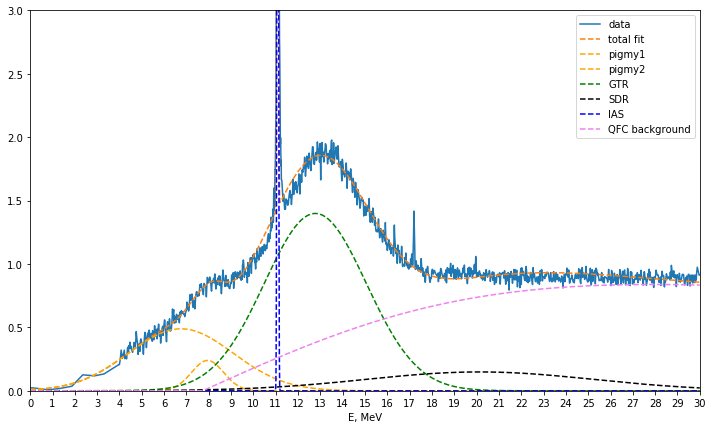

In [79]:
i = 0
plt.figure(figsize=(12,7))
y_fit = total_dataset2PR_gauss(result_gauss_2PR.params, i, data_to_fit_x)
#plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, PR2, IAS1, GTR, SDR, QFC = total_dataset_for_plot2PR_gauss(result_gauss_2PR.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, PR2, 'orange', label='pigmy2', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.xticks(np.arange(0,32,1))
plt.ylim(0,3)
plt.xlim(0,30)
plt.legend()
plt.show()

### оценка коэф. пересчета из Counts в B(GT)

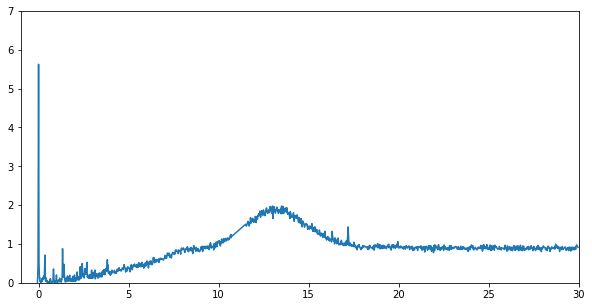

In [102]:
Koeff_data = red_0_4.append(red_4_30[red_4_30['x']<10.75]).append(red_4_30[red_4_30['x']>11.5])

plt.figure(figsize=(10,5))
plt.plot(Koeff_data['x'].values, Koeff_data['y'].values)
plt.ylim(0,7)
plt.xlim(-1,30)
plt.show()

In [103]:
Koeff_data['x'].values

array([-0.06294643, -0.05496351, -0.05095979, ..., 29.84896634,
       29.88453505, 29.96889894])

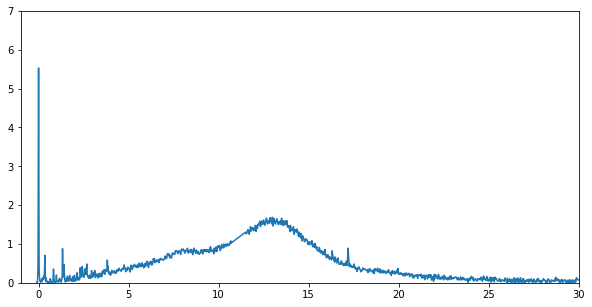

In [106]:
Koeff_x_values = np.arange(-0.1, 30, 0.01)
_, _, _, SDR, QFC = total_dataset_for_plot(result.params, 0, data_to_fit_x)
Koeff_SDR = np.interp(Koeff_x_values, data_to_fit_x, SDR)
Koeff_QFC = np.interp(Koeff_x_values, data_to_fit_x, QFC)

Koeff_y_values = np.interp(Koeff_x_values, Koeff_data['x'].values, Koeff_data['y'].values)
Koeff_y_values = Koeff_y_values - Koeff_SDR - Koeff_QFC

plt.figure(figsize=(10,5))
plt.plot(Koeff_x_values, Koeff_y_values)
plt.ylim(0,7)
plt.xlim(-1,30)
plt.show()

In [113]:
int_0_3 = trapz(Koeff_y_values[Koeff_x_values<3], Koeff_x_values[Koeff_x_values<3])
BGT_0_3 = 0.602
koef = BGT_0_3 / int_0_3

int_0_3, koef

(0.5701075811255696, 1.0559410538120977)

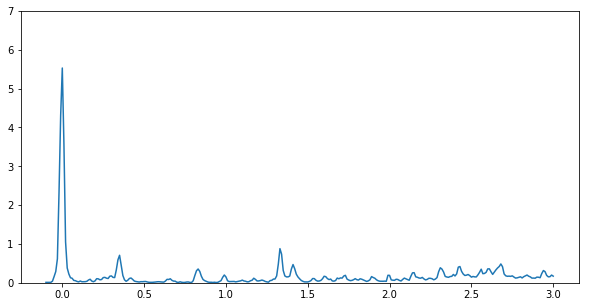

In [110]:
#Koeff_x_values[Koeff_x_values<3]
plt.figure(figsize=(10,5))
plt.plot(Koeff_x_values[Koeff_x_values<3], Koeff_y_values[Koeff_x_values<3])
plt.ylim(0,7)dd
#plt.xlim(-1,30)
plt.show()

In [115]:
Koeff_y_norm = Koeff_y_values * koef

trapz(Koeff_y_norm[Koeff_x_values<3], Koeff_x_values[Koeff_x_values<3]), trapz(Koeff_y_norm, Koeff_x_values)

(0.6019999999999999, 15.425778383302141)

## data from 1985

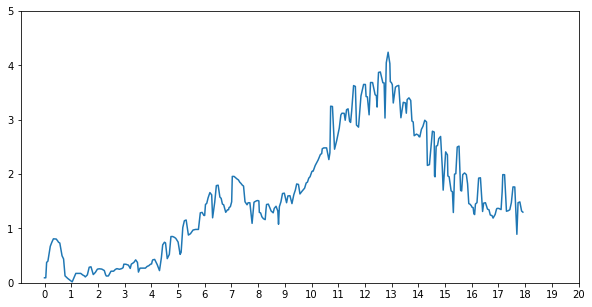

In [61]:
data1985 = pd.read_csv('../B(GT) peaks processing/recognition/Mo98/bgt 1985.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
#data1985['x'] = -data1985['x'] + 120

plt.figure(figsize=(10,5))
plt.plot(data1985['x'].values, data1985['y'].values)
plt.xticks(np.arange(0,21,1))
plt.ylim(0,5)
plt.show()

In [74]:
total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3, prefix='pigmy2_') \
+Model(breit_vigner3, prefix='GTR_')

total_mod.set_param_hint('pigmy1_w', value=9, min=5, max=11)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy1_M', value=5, min=0.1, max=10)

total_mod.set_param_hint('pigmy2_w', value=0.5, min=0, max=1)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=3)
total_mod.set_param_hint('pigmy2_M', value=1, min=0.1, max=2)

total_mod.set_param_hint('GTR_w', value=13, min=11, max=16)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=5)
total_mod.set_param_hint('GTR_M', value=5, min=0.1, max= 30)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data1985['y'].values, pars, x=data1985['x'].values, 
                                 method='differential_evolution')

print(tиotal_mod_result.fit_report())

[[Model]]
    ((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='GTR_'))
[[Fit Statistics]]
    # function evals   = 6896
    # data points      = 306
    # variables        = 9
    chi-square         = 18.323
    reduced chi-square = 0.062
    Akaike info crit   = -843.527
    Bayesian info crit = -810.015
[[Variables]]
    pigmy1_M:    0.96754379 (init= 5)
    pigmy1_w:    6.58178327 (init= 9)
    pigmy1_G1:   1.09240700 (init= 0.1)
    pigmy2_M:    0.46610111 (init= 1)
    pigmy2_w:    0.15916130 (init= 0.5)
    pigmy2_G1:   0.29357117 (init= 0.1)
    GTR_M:       10.9465331 (init= 5)
    GTR_w:       12.6613229 (init= 13)
    GTR_G1:      3.07773403 (init= 2)



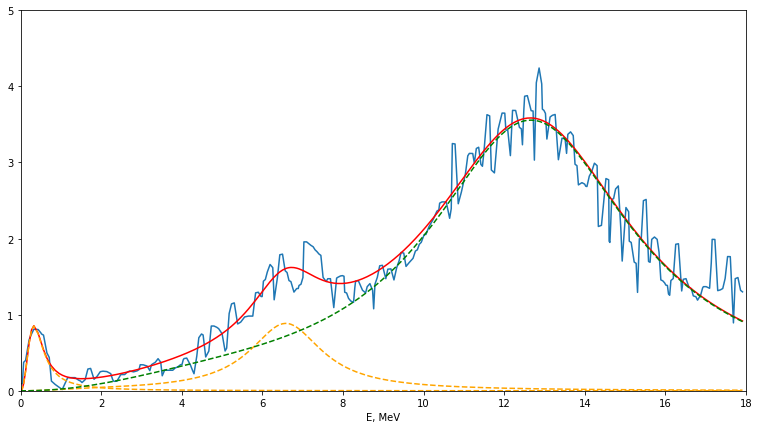

In [87]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data1985['x'].values, data1985['y'].values, label='experimental data')
plt.plot(data1985['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data1985['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data1985['x'].values, total_mod_comps['pigmy2_'], 'orange', label='pigmy2', ls='--')
plt.plot(data1985['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,5)
plt.xlim(0,18)
plt.show()

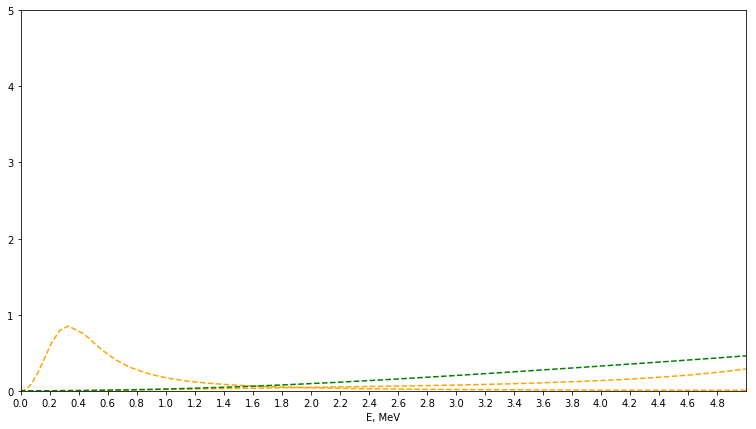

In [93]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data1985['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data1985['x'].values, total_mod_comps['pigmy2_'], 'orange', label='pigmy2', ls='--')
plt.plot(data1985['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.xlabel('E, MeV')
plt.xticks(np.arange(0,5,0.2))
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

In [88]:
print(total_mod_result.fit_report())

[[Model]]
    ((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='GTR_'))
[[Fit Statistics]]
    # function evals   = 6896
    # data points      = 306
    # variables        = 9
    chi-square         = 18.323
    reduced chi-square = 0.062
    Akaike info crit   = -843.527
    Bayesian info crit = -810.015
[[Variables]]
    pigmy1_M:    0.96754379 (init= 5)
    pigmy1_w:    6.58178327 (init= 9)
    pigmy1_G1:   1.09240700 (init= 0.1)
    pigmy2_M:    0.46610111 (init= 1)
    pigmy2_w:    0.15916130 (init= 0.5)
    pigmy2_G1:   0.29357117 (init= 0.1)
    GTR_M:       10.9465331 (init= 5)
    GTR_w:       12.6613229 (init= 13)
    GTR_G1:      3.07773403 (init= 2)



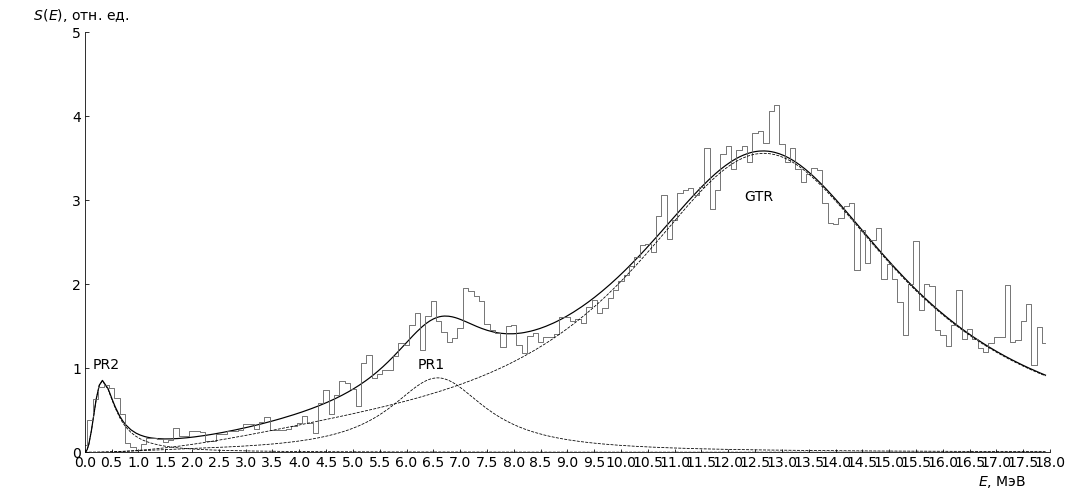

In [86]:
f, ax = plt.subplots(figsize=(15,7))

x_1985_step = np.arange(0,18,0.1)
y_1985_step = np.interp(x_1985_step, data1985['x'].values, data1985['y'].values)

ax.plot(data1985['x'].values, total_mod_result.best_fit, 'k', ls='-', linewidth=1.2, label='total fit')
ax.step(x_1985_step, y_1985_step, where='mid', color='dimgrey', linewidth=0.9)

ax.plot(data1985['x'].values, total_mod_comps['pigmy1_'], 'k', label='pigmy1', ls='--', linewidth=0.8)
ax.plot(data1985['x'].values, total_mod_comps['pigmy2_'], 'k', label='pigmy2', ls='--', linewidth=0.8)
ax.plot(data1985['x'].values, total_mod_comps['GTR_'], 'k', label='pigmy1', ls='--', linewidth=0.8)


ax.text(12.3, 3.0, 'GTR',  fontsize=14)
ax.text(6.2, 1, 'PR1',  fontsize=14)
ax.text(0.15, 1, 'PR2',  fontsize=14)

ax.set_ylabel('      $S(E)$, отн. ед.', x=0, y=1.02, rotation=0, fontsize=14)
ax.set_xlabel('$E$, МэВ', x=0.95, y=-0.15, fontsize=14)
ax.set_xticks(np.arange(0,19,0.5))

ax.tick_params(direction='in', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.ylabel('S(E), 1/MeV')
ax.set_ylim(0,5)
ax.set_xlim(0,18)
#plt.legend()
plt.tight_layout()
plt.show()